依赖

In [77]:
import pandas as pd
import yfinance as yf
import arrow
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
import scipy.interpolate as sci

获取一些股票在一段时间内每日的价格数据

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'Normalized Stock Prices'}, xlabel='Date'>

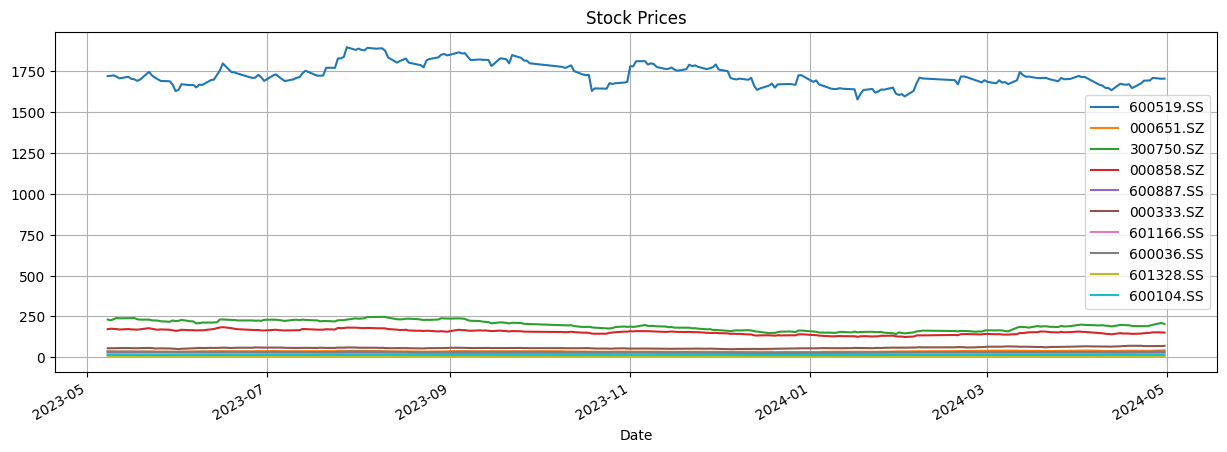

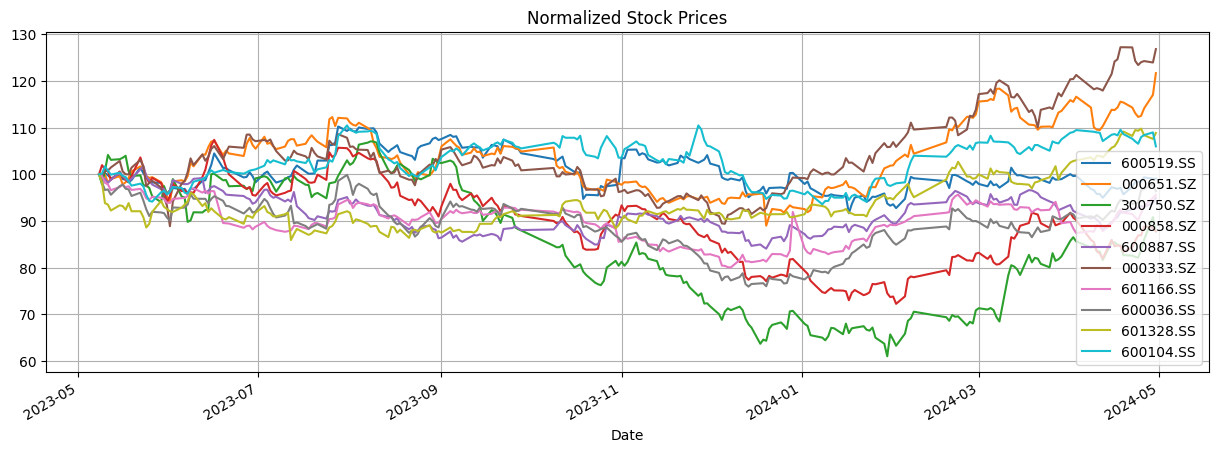

In [78]:
# 股票代码
stocks = [
    '600519.SS',
    '000651.SZ',
    '300750.SZ',
    #'601318.SS',
    '000858.SZ', '600887.SS', '000333.SZ', '601166.SS', '600036.SS', '601328.SS', '600104.SS']
number_of_assets = len(stocks)

# 时间范围
now = arrow.now()
start_date = now.shift(years = -1).format("YYYY-MM-DD")
end_date = now.format("YYYY-MM-DD")

# dataFrame
data = pd.DataFrame()

# 逐个获取每只股票的价格并加入 DataFrame 中
for stock in stocks:
    stock_data = yf.download(stock, start=start_date, end=end_date)
    data[stock] = stock_data['Close']

# 整理一下数据，让所有股票日期保持一致，不存在空数据的情况
data = data.dropna()

# 数据保存下来
data.to_excel('data.xlsx')

# 绘制每只股票的收盘价曲线
data.plot(figsize=(15, 5), grid=True, title='Stock Prices')

# 绘制标准化以后每只股票的走势情况
(data / data.iloc[0] * 100).plot(figsize=(15, 5), grid=True, title='Normalized Stock Prices')

计算统计分析数据

* 个股收益率（对数收益率）
* 个股年化收益率
* 协方差矩阵（年化方差）

In [79]:
# 计算对数收益率
rets = np.log(data / data.shift(1))

# 年化收益率
year_ret = rets.mean() * 252

# 协方差矩阵 （年化方差）
year_volatility = rets.cov() * 252


array([[<Axes: title={'center': '600519.SS'}>,
        <Axes: title={'center': '000651.SZ'}>,
        <Axes: title={'center': '300750.SZ'}>],
       [<Axes: title={'center': '000858.SZ'}>,
        <Axes: title={'center': '600887.SS'}>,
        <Axes: title={'center': '000333.SZ'}>],
       [<Axes: title={'center': '601166.SS'}>,
        <Axes: title={'center': '600036.SS'}>,
        <Axes: title={'center': '601328.SS'}>],
       [<Axes: title={'center': '600104.SS'}>, <Axes: >, <Axes: >]],
      dtype=object)

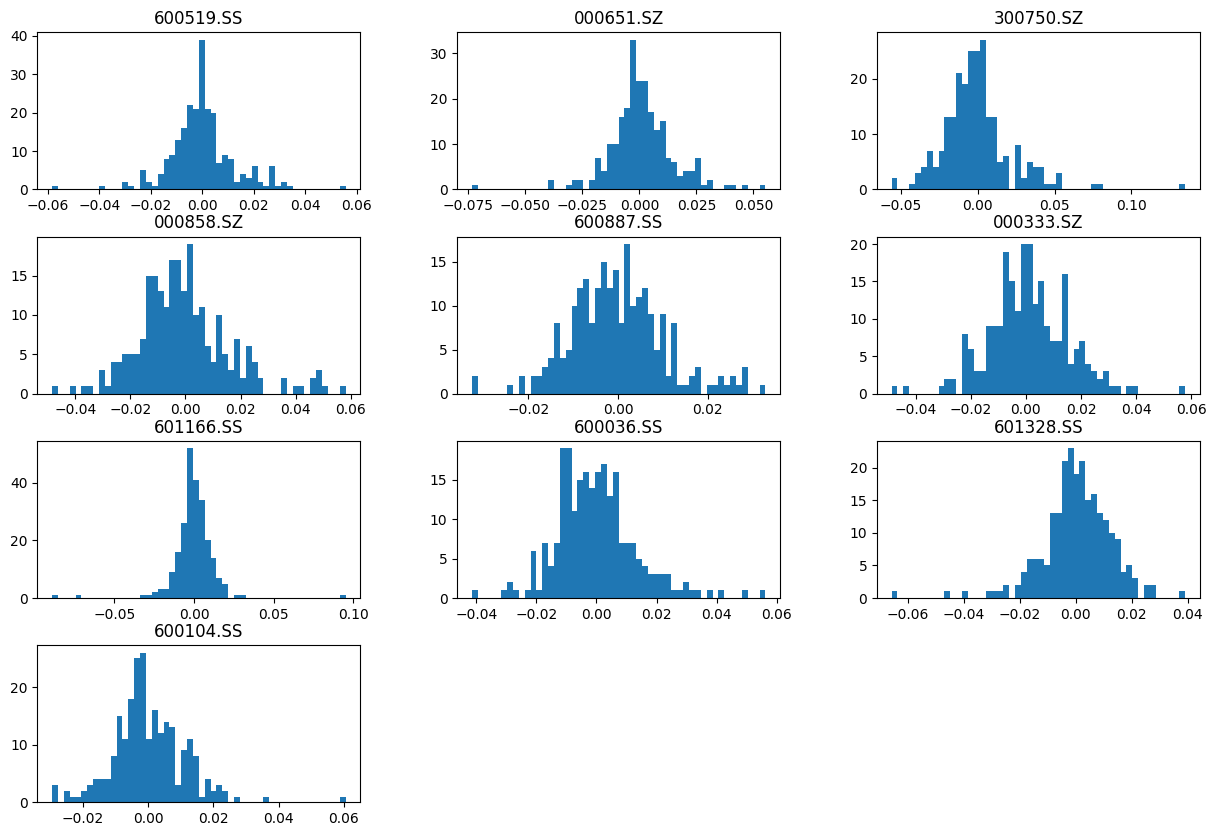

In [80]:
# 可视化一下
rets.hist(bins=50, figsize=(15, 10), grid=False)

随机权重，并计算指标

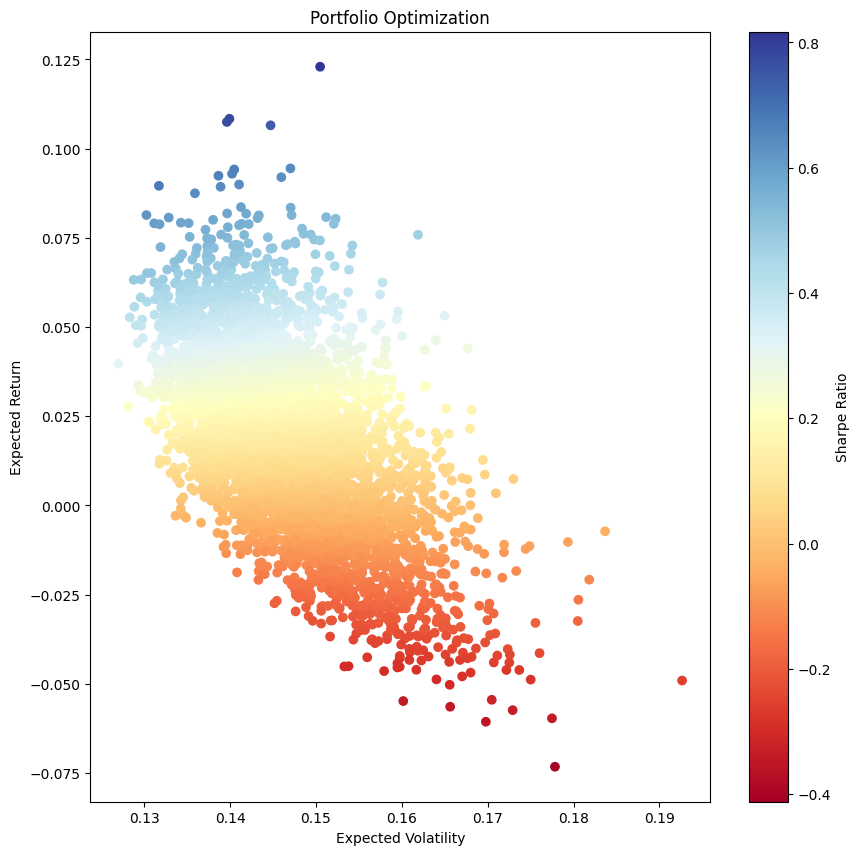

In [81]:
# 随机生成多组归一化的权重，计算对应的组合收益率和波动率（标准差）
portfolio_returns = []
portfolio_volatilities = []
for p in range(5000):
    weights = np.random.random(number_of_assets)
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(rets.mean() * weights) * 252)
    portfolio_volatilities.append(np.sqrt(np.dot(
        weights.T, np.dot(
        year_volatility,
        weights)))
    )

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

# 计算夏普率
portfolio_sharpe = portfolio_returns / portfolio_volatilities

# 可视化
plt.figure(figsize=(10, 10))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_sharpe, cmap='RdYlBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Portfolio Optimization')
plt.show()

使用优化器计算最优点

In [82]:
# 根据所给权重计算组合收益率、波动率、夏普率
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(year_volatility, weights)))
    return np.array([pret, pvol, pret / pvol])

In [83]:
# 使用最小化优化器，目标为最小化负夏普率（即最大夏普率）
def min_func_sharpe(weights):
    return -statistics(weights)[2]

# 使用最小优化器，目标为最小化波动率
def min_func_volatilitiy(weights):
    return statistics(weights)[1]

# 使用最小优化器，目标为最小化方差
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

# 使用最小优化器，目标为最小化负收益率（即最大收益率）
def min_func_return(weights):
    return -statistics(weights)[0]

In [84]:
# 使用优化器求解夏普率最优点
bnds = tuple((0, 1) for x in range(number_of_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
opts = sco.minimize(
    min_func_sharpe,                                # 优化目标
    number_of_assets * [1. / number_of_assets],     # 初始值
    method='SLSQP',                                 # 优化器 Sequential Least Squares Programming
    bounds=bnds,                                    # 边界条件（参数权重在 0, 1 之间）
    constraints=cons                                # 约束条件（参数和为 1）
)
opt_sharp = opts['x']

# 使用优化器求解波动率最低点
bnds = ((0, 1) for x in range(number_of_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
opts = sco.minimize(
    min_func_variance,                              # 优化目标
    number_of_assets * [1. / number_of_assets],     # 初始值
    method='SLSQP',                                 # 优化器 Sequential Least Squares Programming
    bounds=bnds,                                    # 边界条件（参数权重在 0, 1 之间）
    constraints=cons                                # 约束条件（参数和为 1）
)
opt_vol = opts['x']

print('opt_sharp: ', opt_sharp)
print('opt_vol  : ', opt_vol)

opt_sharp:  [4.12882930e-17 2.40252125e-01 0.00000000e+00 1.64754462e-16
 0.00000000e+00 5.50058615e-01 0.00000000e+00 3.14872228e-17
 1.97349041e-01 1.23402190e-02]
opt_vol  :  [5.96452461e-02 6.67766761e-02 1.50822174e-02 0.00000000e+00
 2.25127532e-01 8.41331211e-02 6.27941842e-02 3.90312782e-18
 2.47117405e-01 2.39323618e-01]


有效边界

各个收益率下波动率最小的点

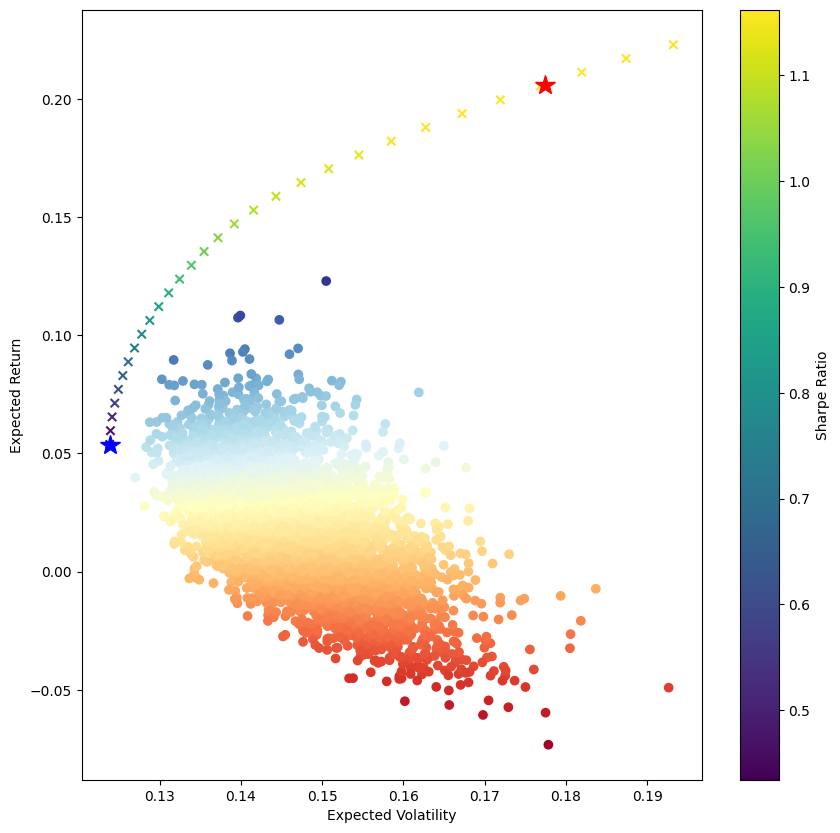

In [85]:
# 计算有效边界
min_return = statistics(opt_vol)[0]             # 要计算的最小收益率为波动率最小的点对应的收益率
max_return = np.max(portfolio_returns) + 0.1    # 要计算的最大收益率为前面随机出的最大收益率再高一点
target_returns = np.linspace(min_return, max_return, 30)
target_volatilities = []
for tret in target_returns:
    bnds = tuple((0, 1) for x in range(number_of_assets))
    cons = (
        {'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},   # 收益率不变
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}              # 参数和为 1
    )
    res = sco.minimize(
        min_func_volatilitiy,
        number_of_assets * [1. / number_of_assets], 
        method='SLSQP',
        bounds=bnds,
        constraints=cons
    )
    target_volatilities.append(res['fun'])   # fun 成员是最优函数输出值，即最小波动率

# 作图
plt.figure(figsize=(10, 10))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_sharpe, cmap='RdYlBu')
plt.scatter(target_volatilities, target_returns, c=target_returns/target_volatilities, marker='x')
plt.plot(statistics(opt_sharp)[1], statistics(opt_sharp)[0], 'r*', markersize=15)
plt.plot(statistics(opt_vol)[1], statistics(opt_vol)[0], 'b*', markersize=15)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()

资本市场线
经过无风险资产收益率的点，且和有效边界相切的直线

假设无风险资产收益率为 2%，即点 (0, 2)，那么应满足三个条件：

f(0) = a (= risk_free_return)

f(x) = a + b * x

df(x) = b

[0.02       1.05205866 0.1858394 ]


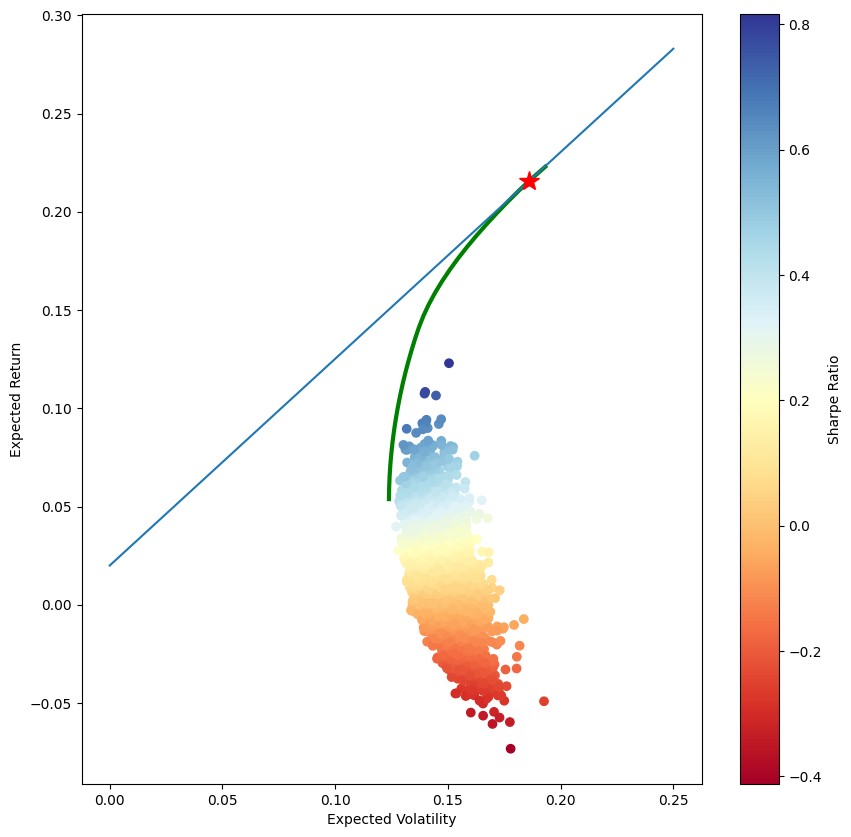

In [86]:
tck = sci.splrep(target_volatilities, target_returns)

# 有效边界的插值得到 f(x)
def f(x):
    return sci.splev(x, tck, der=0)

# 一阶导
def df(x):
    return sci.splev(x, tck, der=1)

# p = (a, b, x)
def equations(p, risk_free_return=0.02):
    eq1 = risk_free_return - p[0]
    eq2 = risk_free_return + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.7, 0.18])

print(opt)

# 作图
plt.figure(figsize=(10, 10))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_sharpe, cmap='RdYlBu')
plt.plot(target_volatilities, target_returns, 'g', lw=3.0)

# 资本市场线
cml_x = np.linspace(0.0, 0.25)
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)

# 资本市场线与有效边界的切点
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15)


plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()